In [1]:
from Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from BaggingSA import BaggingSA

seed = 42
np.random.seed(seed)
random.seed(seed)
data = datasets.load_digits()


X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [2]:
def evaluate_bagging_sa(n_trees):
    bagging_sa = BaggingSA(X=X_train, y=y_train,
                                T0=10, alpha=0.01, cooling_method= 'logarithmic', max_iterations=4000, n_trees=n_trees,
                                feature_mutation_chance=0.3, test_split_amount=10)
    models = bagging_sa.run(X_for_test=X_test, y_for_test=y_test, monitor_fun=fun_monitor)
    accuracy = evaluate(X_test, y_test, models=models)
    return accuracy, models


fit_acc_sum = {}
run_through_res = []

def fun_monitor(iteration, T, best_fitness, fitness, new_fitness, accuracy):
    print(f"I: {iteration}, T: {T:.3f}, Best fitness: {best_fitness:.3f}, Fitness: {fitness:.3f}, New fitness: {new_fitness:.3f}, Accuracy: {accuracy:.3f}")
    if iteration not in fit_acc_sum:
        fit_acc_sum[new_fitness] = [accuracy]
    else:
        fit_acc_sum[new_fitness].append(accuracy)
    run_through_res.append([iteration, T, best_fitness, fitness, new_fitness, accuracy])

acc_sa, models = evaluate_bagging_sa(n_trees=5)
df = pd.DataFrame(run_through_res, columns=['Iteration', 'T', 'BestFitness', 'Fitness', 'NewFitness', 'Accuracy'])

df.to_csv('./../res/bagging_sa_details.csv', index=False)

print(f"BaggingSA: {acc_sa:.3f}")

I: 1, T: 10.000, Best fitness: 0.858, Fitness: 0.858, New fitness: 0.840, Accuracy: 0.861
I: 2, T: 0.014, Best fitness: 0.858, Fitness: 0.840, New fitness: 0.833, Accuracy: 0.853
I: 3, T: 0.009, Best fitness: 0.858, Fitness: 0.833, New fitness: 0.833, Accuracy: 0.864
I: 4, T: 0.007, Best fitness: 0.858, Fitness: 0.833, New fitness: 0.806, Accuracy: 0.836
I: 5, T: 0.006, Best fitness: 0.858, Fitness: 0.833, New fitness: 0.823, Accuracy: 0.839
I: 6, T: 0.006, Best fitness: 0.858, Fitness: 0.833, New fitness: 0.833, Accuracy: 0.847
I: 7, T: 0.005, Best fitness: 0.858, Fitness: 0.833, New fitness: 0.865, Accuracy: 0.850
I: 8, T: 0.005, Best fitness: 0.865, Fitness: 0.865, New fitness: 0.847, Accuracy: 0.853
I: 9, T: 0.005, Best fitness: 0.865, Fitness: 0.865, New fitness: 0.841, Accuracy: 0.867
I: 10, T: 0.004, Best fitness: 0.865, Fitness: 0.865, New fitness: 0.843, Accuracy: 0.850
I: 11, T: 0.004, Best fitness: 0.865, Fitness: 0.865, New fitness: 0.778, Accuracy: 0.839
I: 12, T: 0.004, B

In [3]:
from Bagging import predict

for i, model in enumerate(models):
    y_pred = predict(X_test, [model])
    acc = accuracy_score(y_test, y_pred)
    print(f"Model [{i}] accuracy: {acc:.3f}")


Model [0] accuracy: 0.586
Model [1] accuracy: 0.581
Model [2] accuracy: 0.689
Model [3] accuracy: 0.681
Model [4] accuracy: 0.506


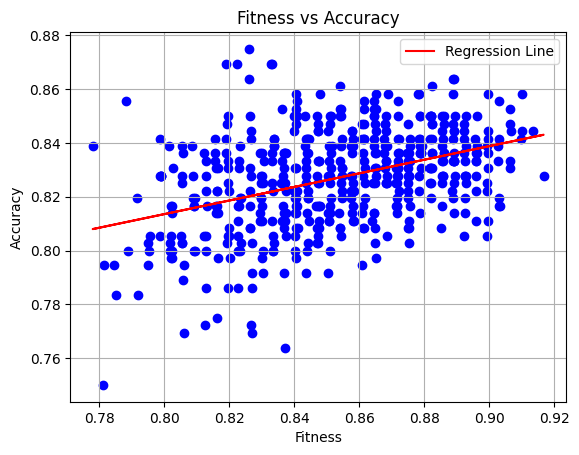

Correlation between fitness and accuracy: 0.403


In [4]:
import matplotlib.pyplot as plt

X = np.array(list(fit_acc_sum.keys()))
Y = np.array([np.mean(fit_acc_sum[x]) for x in X])

coefficients = np.polyfit(X, Y, 1) 
regression_line = np.poly1d(coefficients)

Y_regression = regression_line(X)

plt.scatter(X, Y, color="blue")
plt.plot(X, Y_regression, label="Regression Line", color="red")


plt.xlabel("Fitness")
plt.ylabel("Accuracy")
plt.title("Fitness vs Accuracy")
plt.grid()
plt.legend()
plt.show()

correlation = np.corrcoef(X, Y)[0, 1]
print(f"Correlation between fitness and accuracy: {correlation:.3f}")


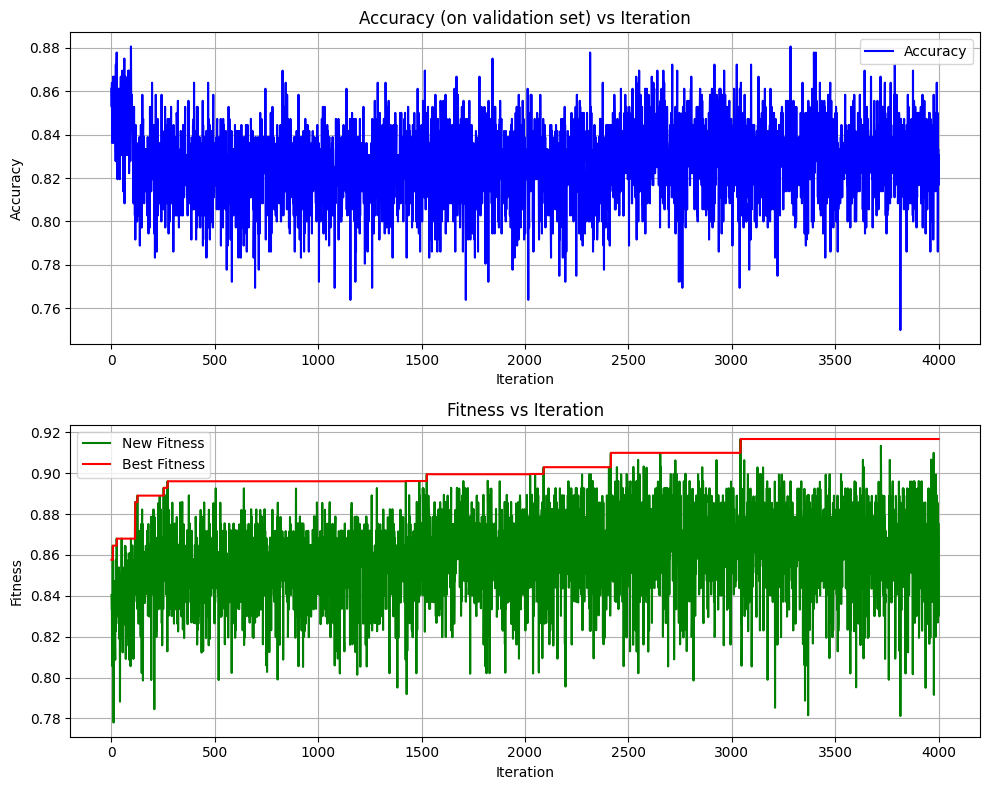

In [5]:
X = df['Iteration']
Y1 = df['Accuracy']

Y2 = df['NewFitness']
Y2_2 = df['BestFitness']

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(X, Y1, label="Accuracy", color="blue")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy (on validation set) vs Iteration")
axs[0].grid()   
axs[0].legend()

axs[1].plot(X, Y2, label="New Fitness", color="green")
axs[1].plot(X, Y2_2, label="Best Fitness", color="red")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Fitness")
axs[1].set_title("Fitness vs Iteration")
axs[1].grid()
axs[1].legend()



plt.tight_layout()
plt.show()